<a href="https://colab.research.google.com/github/aw814/dragonnet/blob/master/Demo_RHC_Dragonnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports


In [ ]:
!pip install pandas==1.5.0
!pip install scikit-learn
!pip install --upgrade tensorflow
!pip install --upgrade keras

In [ ]:
import os
import glob
import argparse
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Use TensorFlow's Keras API
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau, TerminateOnNaN
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import binary_accuracy
from tensorflow.keras.layers import Layer

# For using Keras backend functions directly
import tensorflow.keras.backend as K
from keras.losses import binary_crossentropy
import copy
from numpy import load
import numpy as np
from scipy.special import logit, expit
from scipy.optimize import minimize
import pandas as pd


#Dataset


## Data Description


* 5,735 subjects,

* 1 outcome variable (
Y
  = death),
1 exposure variable (
T
  = RHC status), and
60 covariates (X).


## Import Data and extract treatment, covariates and outcomes


Performed the same Data Transformation as 1.2 Analytic data section of the TMLE tutorial. The file is saved as a csv format in google drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
DATA_BASE_DIR = '/content/drive/MyDrive/Dragonnet_SPPH'
DATA_PATH = os.path.join(DATA_BASE_DIR, 'rhc3.csv')
print(DATA_PATH)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Dragonnet_SPPH/rhc3.csv


In [ ]:
import pandas as pd

# Read the CSV file into a pandas DataFrame
df_final = pd.read_csv(DATA_PATH,index_col=0)
# # Display the DataFrame
# df.head()

## Data analysis (Need to find better way to represent all the variables)

In [ ]:
# Use describe() to get initial summary statistics for numeric columns
summary = df_final.describe()

# Calculate additional statistics
summary.loc['min'] = df_final.min()
summary.loc['max'] = df_final.max()
summary.loc['mean'] = df_final.mean()
summary.loc['std'] = df_final.std()
summary.loc['25%'] = df_final.quantile(0.25)
summary.loc['50%'] = df_final.median()
summary.loc['75%'] = df_final.quantile(0.75)

# Transpose the summary DataFrame for a better layout
summary = summary.transpose()

# Display the summary DataFrame
print("Summary of each column:")
print(summary)

Summary of each column:
             count          mean          std       min          25%  \
tx          5735.0  3.808195e-01     0.485631  0.000000     0.000000   
death       5735.0  3.344377e-01     0.471835  0.000000     0.000000   
sex.Female  5735.0  4.434176e-01     0.496831  0.000000     0.000000   
race.black  5735.0  1.604185e-01     0.367026  0.000000     0.000000   
race.other  5735.0  6.190061e-02     0.240996  0.000000     0.000000   
...            ...           ...          ...       ...          ...   
pot1        5735.0  4.144316e-16     1.000000 -2.885040    -0.648407   
crea1       5735.0 -8.672710e-17     1.000000 -0.990232    -0.551862   
bili1       5735.0 -1.362854e-16     1.000000 -0.451330    -0.305556   
alb1        5735.0 -1.647815e-16     1.000000 -3.565477    -0.629577   
id          5735.0  2.868000e+03  1655.696228  1.000000  1434.500000   

                    50%          75%          max  
tx             0.000000     1.000000     1.000000  
death  

In [ ]:
summary.loc['death']

,death
count,5735.000000
mean,0.334438
std,0.471835
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


### Variables Description

- **x**: Covariates - These are the independent variables used in the analysis.
- **t**: Treatment - This indicates whether the treatment was applied or not.
- **y**: Factual Outcome - The outcome observed under the treatment or control given to the subject.
- **mu_0**: Noiseless Potential Outcome (Control) - The estimated outcome if the subject did not receive the treatment.
- **mu_1**: Noiseless Potential Outcome (Treatment) - The estimated outcome if the subject did receive the treatment.



# Motivation

* Improve the estimation of treatment effects from observational data using neural networks.

* Address the challenge of potential confounding factors that can lead to incorrect causal conclusions if not properly adjusted for.

Dragonnet Architecture: This new neural network architecture **utilizes the sufficiency of the propensity score** for causal estimation, aiming to better adjust for confounding factors in the estimation process.

These adaptations are based on insights from statistical literature on treatment effect estimation and are intended to outperform existing methods.







# The two steps for using neural networks to estimate treatment effects:

1. Fit models for the conditional outcome and the propensity score.
2. Plug predictions from the models into a dowstream estimator


# Step 1: Model for the conditional outcome and the propensity score

- The model for the conditional outcome:
$$
Q(t, x) = \mathbb{E}[Y \mid t, x]
$$
where \( Q(t, x) \) represents the expected value of the outcome \( Y \) given the treatment \( t \) and covariates \( x \).

- The model for the propensity score:
$$
g(x) = P(T = 1 \mid x)
$$
where \( g(x) \) estimates the probability of receiving the treatment given the covariates \( x \).


## Proposed models: Dragonnet
---

General steps for each of the model will be:
1.   Make the model by defining model architecture
2.   train/fit the model
3.   make predictions
4.   store the predicted outputs ŷ_0, ŷ_1 and ĝ




## 🐲 Dragonnet

### 1. Model architecture

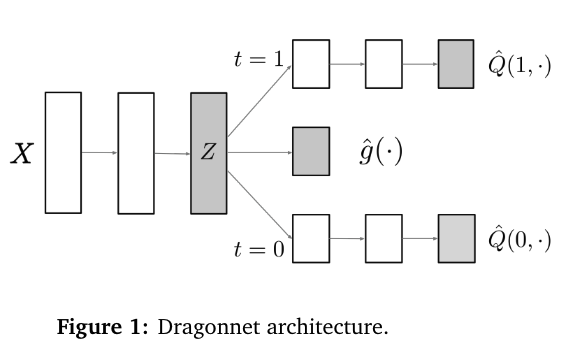

In [ ]:
def make_dragonnet(input_dim, reg_l2):

    inputs = Input(shape=(input_dim,), name='input')

    # representation
    x = Dense(units=200, activation='elu', kernel_initializer='RandomNormal')(inputs)
    x = Dense(units=200, activation='elu', kernel_initializer='RandomNormal')(x)
    x = Dense(units=200, activation='elu', kernel_initializer='RandomNormal')(x)

    # t_predictions = Dense(units=1, activation='sigmoid')(inputs)
    # ***** (3) propensity score g layer ****
    t_predictions = Dense(units=1, activation='sigmoid')(x)

    # HYPOTHESIS
    y0_hidden = Dense(units=100, activation='elu', kernel_regularizer=regularizers.l2(reg_l2))(x)
    y1_hidden = Dense(units=100, activation='elu', kernel_regularizer=regularizers.l2(reg_l2))(x)

    # second layer
    y0_hidden = Dense(units=100, activation='elu', kernel_regularizer=regularizers.l2(reg_l2))(y0_hidden)
    y1_hidden = Dense(units=100, activation='elu', kernel_regularizer=regularizers.l2(reg_l2))(y1_hidden)

    # third
    y0_predictions = Dense(units=1, activation='sigmoid', kernel_regularizer=regularizers.l2(reg_l2), name='y0_predictions')(
        y0_hidden)
    y1_predictions = Dense(units=1, activation='sigmoid', kernel_regularizer=regularizers.l2(reg_l2), name='y1_predictions')(
        y1_hidden)

    concat_pred = Concatenate(1)([y0_predictions, y1_predictions, t_predictions])

    model = Model(inputs=inputs, outputs=concat_pred)

    return model

### 2. fit model



#### Loss function


The loss function (the objective function) is defined and dependent on the two terms:
* Cross-entropy loss for the two classification tasks: the exposure model (proensity score prediction) and the outcome model.
*  The Dragonnet architecture integrates both the exposure model and the outcome model by summing the two losses during training. See dragonnet_loss_binarycross function.

In [ ]:
# Define the loss functions
# minimize errors/loss for propensity score prediction (for exposure model)
def binary_classification_loss(concat_true, concat_pred):
    t_true = concat_true[:, 1]
    t_pred = concat_pred[:, 2]
    # stabilizing the training process by avoiding issues with logarithmic calculations
    # in the next step (binary cross-entropy)
    t_pred = (t_pred + 0.001) / 1.002
    # Binary cross-entropy loss is a common choice for binary classification tasks
    # it measures the "distance" between the actual t and the predicted t
    losst = tf.reduce_sum(binary_crossentropy(t_true, t_pred))

    return losst

# minimize prediction errors separately for treated and untreated groups(for outcome model)
def y_loss(concat_true, concat_pred):
    y_true = tf.cast(concat_true[:, 0], tf.float32)
    t_true = tf.cast(concat_true[:, 1], tf.float32)

    y0_pred = tf.cast(concat_pred[:, 0], tf.float32)
    y1_pred = tf.cast(concat_pred[:, 1], tf.float32)


    loss0 = tf.reduce_sum((1. - t_true)* binary_crossentropy(y_true, y0_pred))
    loss1 = tf.reduce_sum(t_true * binary_crossentropy(y_true, y1_pred))

    return loss0 + loss1


# minimize both the prediction error for outcome + exposure models.
def dragonnet_loss_binarycross(concat_true, concat_pred):
    return y_loss(concat_true, concat_pred) + binary_classification_loss(concat_true, concat_pred)

# a metric used to evaluate the treatment accuracy, not optimized during training.
def treatment_accuracy(concat_true, concat_pred):
    t_true = concat_true[:, 1]
    t_pred = concat_pred[:, 2]
    return tf.keras.metrics.binary_accuracy(t_true, t_pred)


In [ ]:
# Helper function to split and format the predicted output later
def _split_output(yt_hat, t, y, x, index):
    q_t0 = yt_hat[:, 0].reshape(-1, 1)
    q_t1 = yt_hat[:, 1].reshape(-1, 1)
    g = yt_hat[:, 2].copy()

    if yt_hat.shape[1] == 4:
        eps = yt_hat[:, 3][0]
        print('eps is trained')
    else:
        eps = np.zeros_like(yt_hat[:, 2])
        print('eps will be zero')

    var = "average propensity for treated: {} and untreated: {}".format(g[t.squeeze() == 1.].mean(),
                                                                        g[t.squeeze() == 0.].mean())
    print(var)

    # q_t0,q_t1 -> predicted outcomes under (0,1) treatment
    # g -> predicted propensity score
    # t -> treatment
    # y -> original y before transformation
    # index
    # eps -> epsilon
    return {'q_t0': q_t0, 'q_t1': q_t1, 'g': g, 't': t, 'y': y, 'x': x, 'index': index, 'eps': eps}


####Start training below
>

In [ ]:
TRAIN_OUTPUT_DIR = '/content/train_output_ihdp/dragonnet'

In [ ]:
print('\nRunning dragonnet')
train_outputs = []
test_outputs = []
all_scaled_y = []

metrics = [y_loss, binary_classification_loss, treatment_accuracy]
verbose = 0

# Prepare data for training (by default use all the data for train and prediction)
x_columns = [col for col in df_final.columns if col not in ['tx','death', 'id']]

# Split the DataFrame into x: covariates, t: treatment, and y: outcome

x = df_final[x_columns].to_numpy()
t = df_final[['tx']].to_numpy()
y = df_final[['death']].to_numpy()

i = 0
tf.random.set_seed(i)
np.random.seed(i)
# If you want to get the in-sample or out-sample error:
# i) change the train_test_split criteria
train_index, test_index = train_test_split(np.arange(x.shape[0]), test_size=0.01, random_state=1)
# ii) comment out the following: ----------
all_index = np.append(train_index, test_index)
test_index = all_index
train_index = all_index
# -------------------------------

x_train, x_test = x[train_index], x[test_index]
y_train, y_test = y[train_index], y[test_index]
t_train, t_test = t[train_index], t[test_index]

# two column matrix col1 = y,col 2 = t
yt_train = np.concatenate([y_train, t_train], 1)


# -----------------------------------------------------------------------------
# ********(2) Model Configuration (G-comp) ******************
# Each takes the number of features (x.shape[1]) and a regularization parameter (0.01) as inputs.
dragonnet = make_dragonnet(x.shape[1], 0.01)

# Start training
import time;
start_time = time.time()

# defininig some hyperparameters for training
val_split = 0.2
batch_size = 64
loss = dragonnet_loss_binarycross
metrics = metrics

dragonnet.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss=loss, metrics=metrics)

adam_callbacks = [
    TerminateOnNaN(),
    EarlyStopping(monitor='val_loss', patience=2, min_delta=0.),
    ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=verbose, mode='auto',
                        min_delta=1e-8, cooldown=0, min_lr=0)

]


dragonnet.fit(x_train, yt_train, callbacks=adam_callbacks,
                validation_split=val_split,
                epochs=100,
                batch_size=batch_size, verbose=verbose)

sgd_callbacks = [
    TerminateOnNaN(),
    EarlyStopping(monitor='val_loss', patience=40, min_delta=0.),
    ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=verbose, mode='auto',
                        min_delta=0., cooldown=0, min_lr=0)
]

sgd_lr = 1e-5
momentum = 0.9

dragonnet.compile(optimizer=SGD(learning_rate=sgd_lr, momentum=momentum, nesterov=True), loss=loss,
                    metrics=metrics)
dragonnet.fit(x_train, yt_train, callbacks=sgd_callbacks,
                validation_split=val_split,
                epochs=300,
                batch_size=batch_size, verbose=verbose)

elapsed_time = time.time() - start_time
print("***************************** elapsed_time is: ", elapsed_time)

# -------------------------------------------------------------------------
# Save the summary of the model
train_output_dir = TRAIN_OUTPUT_DIR
if not os.path.exists(train_output_dir):
    os.makedirs(train_output_dir)
with open(os.path.join(train_output_dir, 'dragonnet_summary.txt'), 'w') as f:
    dragonnet.summary(print_fn=lambda x: f.write(x + '\n'))

# make predictions on the outcome and propensity score of the whole dataset using dragonnet
yt_hat_test = dragonnet.predict(x_test)
yt_hat_train = dragonnet.predict(x_train)

# split and save the output of the prediction along with the truth (treatment, outcome, covariates).
# Note: since there's no crossvalidation and data splitting, the training data is the test data,
# therefore, the test outputs are the same as train_outputs.
test_outputs += [_split_output(yt_hat_test, t_test, y_test, x_test, test_index)]
train_outputs += [_split_output(yt_hat_train, t_train, y_train, x_train, train_index)]

# save the outputs
train_output_dir = TRAIN_OUTPUT_DIR
if not os.path.exists(train_output_dir):
    os.makedirs(train_output_dir)

for num, output in enumerate(test_outputs):
    np.savez_compressed(os.path.join(train_output_dir, "{}_replication_test.npz".format(num)),
                        **output)

for num, output in enumerate(train_outputs):
    np.savez_compressed(os.path.join(train_output_dir, "{}_replication_train.npz".format(num)),
                        **output)


Running dragonnet
***************************** elapsed_time is:  58.67137813568115


180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
eps will be zero
average propensity for treated: 0.529384970664978 and untreated: 0.2800387144088745
eps will be zero
average propensity for treated: 0.529384970664978 and untreated: 0.2800387144088745


#### Details of the trained model architecture
The table below reflected the model architecture which is also illustrated in the diagram below. The hidden layer size is 200 for the shared representation layers and 100 for the conditional outcome layers.

In [ ]:
# Define the file path
file_path = os.path.join(train_output_dir, 'dragonnet_summary.txt')

# Read and print the file content
with open(file_path, 'r') as file:
    content = file.read()

print(content)

Model: "functional"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)        │ (None, 60)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 200)            │         12,200 │ input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 200)            │         40,200 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 200)            │         40,200 │ dense_1[0][0]          │
├─────────

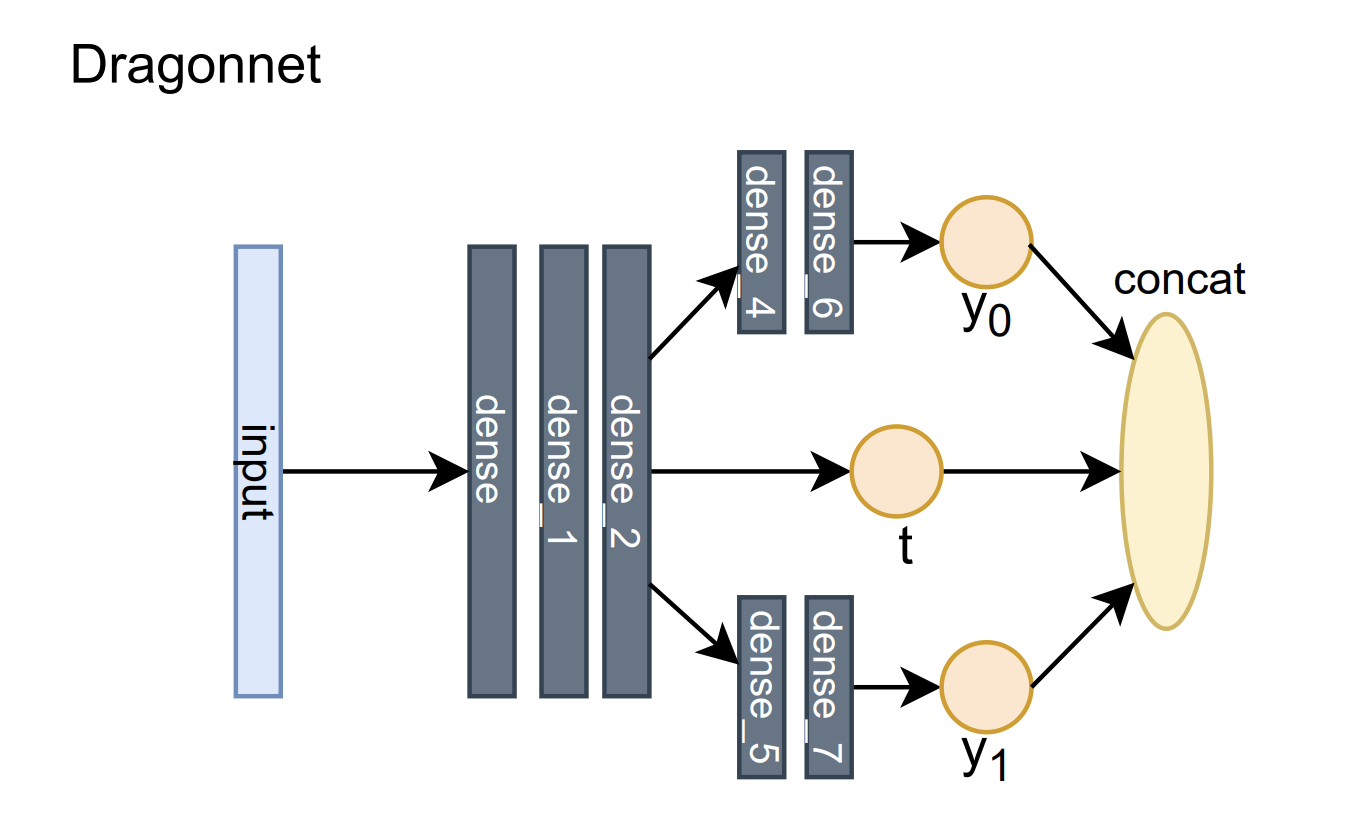

### Predicted outputs description

- **`q_t0`, `q_t1`**: Predicted outcomes under treatments 0 and 1, respectively.
- **`g`**: Predicted propensity score, estimating the probability of receiving the treatment given covariates.
- **`t`**: Indicator of treatment.
- **`y`**: Original outcome variable before any transformations.
- **`index`**: Unique identifier for each observation.



In [ ]:
K.clear_session()

# STEP 2: Estimate ATE (Average Treatment Effect)

After predictions generated, we want to plug them into to the estimator for ATE. There are two estimator:

* natural estimator (1.2)
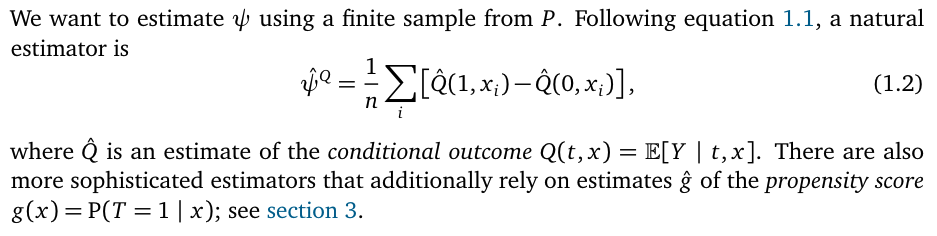

* Targeted Maximum Likelihood Estimation (TMLE):


In [ ]:
def load_data(knob, replication, model, train_test):
    """
    loading train test experiment results
    """
    output_dir = '/content/train_output_ihdp/{}/'.format(knob)
    data = load(output_dir + '{}_replication_{}.npz'.format(replication, train_test))

    # q_t0,q_t1 -> predicted outcomes under (0,1) treatment
    # g -> predicted propensity score
    # t -> treatment
    # y -> original y before transformation
    # index
    # eps -> epsilon
    # NOTE: rechape (-1,1) return a two-dimensional array with one column and as many rows as necessary to accommodate all elements.

    return data['q_t0'].reshape(-1, 1), data['q_t1'].reshape(-1, 1), data['g'].reshape(-1, 1), \
           data['t'].reshape(-1, 1), data['y'].reshape(-1, 1), data['index'].reshape(-1, 1), data['eps'].reshape(-1, 1)


In [ ]:
ESTIMATE_OUTPUT_DIR = os.path.join(DATA_BASE_DIR, 'estimate_output')
if not os.path.exists(ESTIMATE_OUTPUT_DIR):
    os.makedirs(ESTIMATE_OUTPUT_DIR)

In [ ]:
def save_estimations(df, model_name):
    df = df.assign(model=model_name)
    file_path = os.path.join(ESTIMATE_OUTPUT_DIR,'estimates_{}.csv'.format(model_name))
    df.to_csv(file_path)


In [ ]:
# Helper functions, details in Appendix B, the purpose of the truncation
# is to minimize the effect of extreme propensity scores.
def truncate_by_g(attribute, g, level=0.01):
    keep_these = np.logical_and(g >= level, g <= 1.-level)

    return attribute[keep_these]


def truncate_all_by_g(q_t0, q_t1, g, t, y, truncate_level=0.05):
    """
    Helper function to clean up nuisance parameter estimates.
    """

    orig_g = np.copy(g)

    q_t0 = truncate_by_g(np.copy(q_t0), orig_g, truncate_level)
    q_t1 = truncate_by_g(np.copy(q_t1), orig_g, truncate_level)
    g = truncate_by_g(np.copy(g), orig_g, truncate_level)
    t = truncate_by_g(np.copy(t), orig_g, truncate_level)
    y = truncate_by_g(np.copy(y), orig_g, truncate_level)

    return q_t0, q_t1, g, t, y



def cross_entropy(y, p):
    return -np.mean((y*np.log(p) + (1.-y)*np.log(1.-p)))


def mse(x, y):
    return np.mean(np.square(x-y))


In [ ]:
# Average treatment effect estimate (ATE)
def psi_tmle_cont_outcome(q_t0, q_t1, g, t, y, eps_hat=None, truncate_level=0.05):
    q_t0, q_t1, g, t, y = truncate_all_by_g(q_t0, q_t1, g, t, y, truncate_level)


    g_loss = mse(g, t)
    h = t * (1.0/g) - (1.0-t) / (1.0 - g)
    full_q = (1.0-t)*q_t0 + t*q_t1 # predictions from unperturbed model

    if eps_hat is None:
        eps_hat = np.sum(h*(y-full_q)) / np.sum(np.square(h))

    def q1(t_cf):
        # ***** Estimate H ******
        h_cf = t_cf * (1.0 / g) - (1.0 - t_cf) / (1.0 - g)
        full_q = (1.0 - t_cf) * q_t0 + t_cf * q_t1  # predictions from unperturbed model
        # ***** Update predictions with H, eps ******
        return full_q + eps_hat * h_cf

    # ***** average Treatment effect *****
    ite = q1(np.ones_like(t)) - q1(np.zeros_like(t))
    psi_tmle = np.mean(ite)

    # standard deviation computation relies on asymptotic expansion of non-parametric estimator, see van der Laan and Rose p 96
    ic = h*(y-q1(t)) + ite - psi_tmle
    psi_tmle_std = np.std(ic) / np.sqrt(t.shape[0])
    initial_loss = np.mean(np.square(full_q-y))
    final_loss = np.mean(np.square(q1(t)-y))


    return psi_tmle, psi_tmle_std, eps_hat, initial_loss, final_loss, g_loss



## Estimate the ATE and SE
using the `psi_tmle_cont_outcome` function defined above.

In [ ]:
knob = 'dragonnet'
model = 'baseline'
train_test = 'train'
rep = 0
tmle_ATE = []
tmle_standard_errors = []

df = pd.DataFrame(columns=['estimate', 'se', 'model'])
# load predictions y0(q_t0), y1(q_t1), g, y_dragon(true outcome), from the model.
q_t0, q_t1, g, t, y_dragon, index, eps = load_data(knob, rep, model, train_test)
truncate_level=0.01
psi_tmle, psi_tmle_std, eps_hat, initial_loss, final_loss, g_loss = psi_tmle_cont_outcome(q_t0, q_t1, g, t,
                                                                                            y_dragon,
                                                                                            truncate_level=truncate_level)
tmle_ATE.append(psi_tmle)
tmle_standard_errors.append(psi_tmle_std)
df['estimate'] = tmle_ATE
df['se'] = tmle_standard_errors
model_name = '{}_{}_tmle'.format(knob,model)
save_estimations(df,model_name)

In [ ]:
psi_tmle

0.03503441756544231

In [ ]:
psi_tmle_std

0.015502488738846349